# Classical clustering with feature engineering approach

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display

from tqdm import tqdm
import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, mutual_info_score
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler

import sys
sys.path.append('../src')
from utils import *
sys.path.remove('../src')

In [2]:
# load data
df_samples = pd.read_csv('../data/data.csv', index_col='Unnamed: 0')
display(df_samples.head(4))

print('Taking features by feature engineering')
df_props = feature_engineering(df_samples)
display(df_props.head(4))

,id,time,ch0,ch1,ch2
0,1_1,0,372.271894,350.219643,408.527289
1,1_1,1,373.393195,349.845876,411.143658
2,1_1,2,371.898127,350.219643,412.638726
3,1_1,3,371.898127,350.967177,413.386260


Taking features by feature engineering


,id,ch0_mean,ch0_std,ch0_min,ch0_25%,ch0_50%,ch0_75%,ch0_max,ch1_mean,ch1_std,...,ch1_50%,ch1_75%,ch1_max,ch2_mean,ch2_std,ch2_min,ch2_25%,ch2_50%,ch2_75%,ch2_max
0,1_1,372.823823,59.454892,-27.284988,367.412923,370.776826,374.140729,866.018051,344.986750,39.969085,...,356.573682,364.049021,383.858670,399.059928,49.083127,370.403059,378.252165,383.111136,406.658454,866.018051
1,2_1,373.564972,98.170505,-262.758174,368.160457,371.898127,375.262030,1166.152921,343.370364,60.537962,...,356.573682,365.170322,387.970106,403.912357,77.323821,365.917856,380.121000,386.101272,405.910921,1166.152921
2,4_1,375.149900,77.360223,295.275900,351.340944,368.534224,381.242301,1069.721045,345.019610,20.214943,...,346.108207,358.816283,407.032221,410.768178,74.900695,342.370537,384.606204,395.445446,418.618997,1069.721045
3,5_1,373.982345,84.538827,182.772044,349.472109,364.983438,378.625932,1124.291021,346.074879,27.205842,...,349.472109,361.432652,398.809348,408.648764,84.655027,349.098342,377.504631,391.707776,409.648590,1124.291021


In [3]:
points = df_props.drop(['id'], axis=1).to_numpy()
scaler = StandardScaler()
points = scaler.fit_transform(points)

In [4]:
from sklearn.cluster import Birch, AgglomerativeClustering
random_seed = 42
n_clust_approx = 6

clstrs = [KMeans,
         GaussianMixture,
         Birch,
         AgglomerativeClustering]

clstr_labels = ['KMeans',
                'GaussianMixture',
                'Birch',
                'AgglomerativeClustering']

param_grids = [{'init' : ['k-means++', 'random'],
                'algorithm' : ['full', 'elkan']},
              {'covariance_type' : ['full', 'tied', 'spherical'],
               'init_params' : ['kmeans', 'random']},
              {'threshold' : np.linspace(0.1,1,9),
               'branching_factor' : [10, 50, 100]},
              {'linkage' : ['ward', 'average']}]

def customGridSearch(param_dict, estimator, X, label, n_clust):
    best_score_index_ = 0
    best_sil_score_ = 0
    best_mut_score = 0
    best_params_ = {}
    param_grid = ParameterGrid(param_dict)
    for i in tqdm(range(len(param_grid))):
        if label != 'GaussianMixture':
            if label != 'KMeans':
                est = estimator(n_clusters=n_clust, **param_grid[i])
            else:
                est = estimator(n_clusters=n_clust_approx, random_state = random_seed, **param_grid[i])
        else: 
            est = estimator(n_components=n_clust, random_state = random_seed, **param_grid[i])
        
        y_pred = est.fit_predict(X)
        sil_score = silhouette_score(X, y_pred)
        if best_sil_score_ < sil_score:
            best_score_index_ = i
            best_sil_score_ = sil_score
            best_params_ = param_grid[i]
    print(f'For {label} best silhouette score {best_sil_score_: .3f}')
    print(f'Best parameter for {label}: {best_params_}')   
        
    return best_sil_score_, best_params_

best_params_arr = []

for clstr, clstr_label, param_grid in zip(clstrs, clstr_labels, param_grids):
    _, bp = customGridSearch(param_grid, clstr, points, clstr_label, n_clust=n_clust_approx)
    best_params_arr.append(bp)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:01<00:00,  2.27it/s]


For KMeans best silhouette score  0.242
Best parameter for KMeans: {'init': 'k-means++', 'algorithm': 'full'}


100%|██████████| 6/6 [00:00<00:00, 12.57it/s]


For GaussianMixture best silhouette score  0.254
Best parameter for GaussianMixture: {'init_params': 'kmeans', 'covariance_type': 'tied'}


100%|██████████| 27/27 [00:02<00:00, 12.01it/s]


For Birch best silhouette score  0.404
Best parameter for Birch: {'threshold': 0.4375, 'branching_factor': 10}


100%|██████████| 2/2 [00:00<00:00, 93.59it/s]

For AgglomerativeClustering best silhouette score  0.483
Best parameter for AgglomerativeClustering: {'linkage': 'average'}


100%|██████████| 4/4 [00:00<00:00, 95.62it/s]


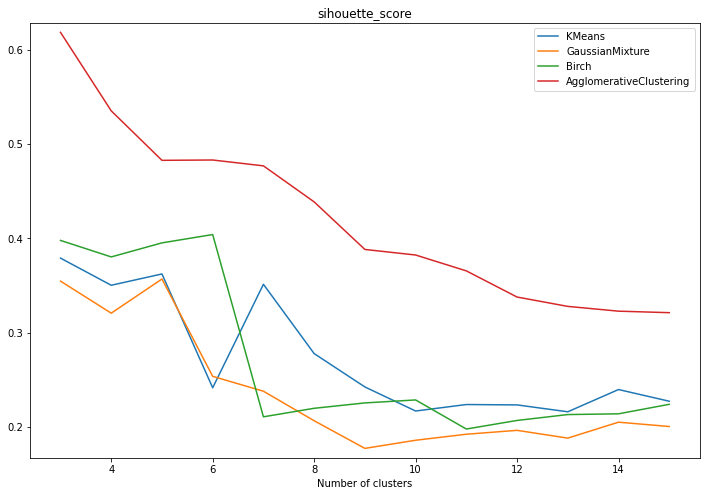

In [5]:
clstr_nums =  range(3,16,1)

def clstr_calc(clstr_fun, best_params, clstr_label, X=points):
    '''
    :param clstr: function;
    :param best_params: dict;
    :param clstr_label: str;
    :return: list.
    '''
    sil_scores = []
    # mut_scores = []
    for i in range(len(clstr_nums)):
        if clstr_label != 'GaussianMixture':
            if clstr_label != 'KMeans':
                clstr = clstr_fun(n_clusters=clstr_nums[i], **best_params)
            else:
                clstr = clstr_fun(n_clusters=clstr_nums[i], random_state = random_seed, **best_params)
        else: 
            clstr = clstr_fun(n_components=clstr_nums[i], random_state = random_seed, **best_params)
        y_pred = clstr.fit_predict(X)
        sil_score = silhouette_score(X, y_pred)
        sil_scores.append(sil_score)
    return sil_scores
        
sils =  []
for clstr, clstr_label,  best_params in zip(clstrs, clstr_labels,  best_params_arr):
    sil = clstr_calc(clstr, best_params, clstr_label)
    sils.append(sil)

plt.figure(figsize=(12,8))
for i in tqdm(range(len(sils))):
    plt.plot(clstr_nums, sils[i], label=clstr_labels[i])
# plt.vlines(15, np.min(sils)-0.01, np.max(sils)+0.01, ls = '--')
plt.ylim(np.min(sils)-0.01, np.max(sils)+0.01)
plt.xlabel('Number of clusters')
plt.legend()
plt.title('sihouette_score')
plt.savefig('../imgs/classical_clustering_sl.png')
plt.show()

In [6]:
from sklearn.utils import resample
from scipy import stats

def conf_int(data, val=0.95):
    return stats.norm.interval(val, np.mean(data, axis=0), np.std(data, axis=0))


clstr_fun = KMeans

scores = []
variances = []
ci = []

for i in clstr_nums:
    sils = []
    for j in tqdm(range(50)):
        X_step = resample(points)
        clstr = clstr_fun(n_clusters=i, random_state = random_seed, **best_params_arr[0])
        y_pred = clstr.fit_predict(X_step)
        sil = silhouette_score(X_step, y_pred)
        sils.append(sil)
    scores.append(np.mean(sils))
    ci.append(conf_int(sils))
    variances.append(np.var(sils))
    print(f'Number of clusters: {i}')
    print(f'\tVariance: {variances[-1]}')
    print(f'\tConfidence interval: {ci[-1]}')

ci0, ci1 = [], []
for item in ci:
    ci0.append(item[0])
    ci1.append(item[1])


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


Number of clusters: 3
	Variance: 0.0013107961794185656
	Confidence interval: (0.3204152632741091, 0.46233593894273184)


100%|██████████| 50/50 [00:14<00:00,  3.50it/s]


Number of clusters: 4
	Variance: 0.0019198996610944872
	Confidence interval: (0.277524420456745, 0.4492825700503999)


100%|██████████| 50/50 [00:14<00:00,  3.36it/s]


Number of clusters: 5
	Variance: 0.002874034190517424
	Confidence interval: (0.2492054314413892, 0.45935284629239004)


100%|██████████| 50/50 [00:14<00:00,  3.48it/s]


Number of clusters: 6
	Variance: 0.0031413250221903888
	Confidence interval: (0.21088247979874056, 0.43058473936982866)


100%|██████████| 50/50 [00:14<00:00,  3.41it/s]


Number of clusters: 7
	Variance: 0.0024666013581893347
	Confidence interval: (0.20271747578585145, 0.3974002695253346)


100%|██████████| 50/50 [00:14<00:00,  3.46it/s]


Number of clusters: 8
	Variance: 0.0010239199031929142
	Confidence interval: (0.22244892765165603, 0.3478817167269962)


100%|██████████| 50/50 [00:14<00:00,  3.41it/s]


Number of clusters: 9
	Variance: 0.0007108710722692099
	Confidence interval: (0.2220273394074087, 0.32654110789644264)


100%|██████████| 50/50 [00:14<00:00,  3.34it/s]


Number of clusters: 10
	Variance: 0.0005931242498293614
	Confidence interval: (0.2305591892721623, 0.3260256730510171)


100%|██████████| 50/50 [00:14<00:00,  3.36it/s]


Number of clusters: 11
	Variance: 0.00046305739666422665
	Confidence interval: (0.23171662706618884, 0.3160686494700044)


100%|██████████| 50/50 [00:15<00:00,  3.24it/s]


Number of clusters: 12
	Variance: 0.000486369809743169
	Confidence interval: (0.24002034848469622, 0.3264696306276318)


100%|██████████| 50/50 [00:15<00:00,  3.20it/s]


Number of clusters: 13
	Variance: 0.00044355345269683565
	Confidence interval: (0.24732180507156373, 0.329878266316256)


100%|██████████| 50/50 [00:15<00:00,  3.15it/s]


Number of clusters: 14
	Variance: 0.00039663162158598943
	Confidence interval: (0.2544274415131078, 0.33249520800626975)


100%|██████████| 50/50 [00:15<00:00,  3.18it/s]

Number of clusters: 15
	Variance: 0.0005156752124448366
	Confidence interval: (0.25620728414708155, 0.3452229028543519)


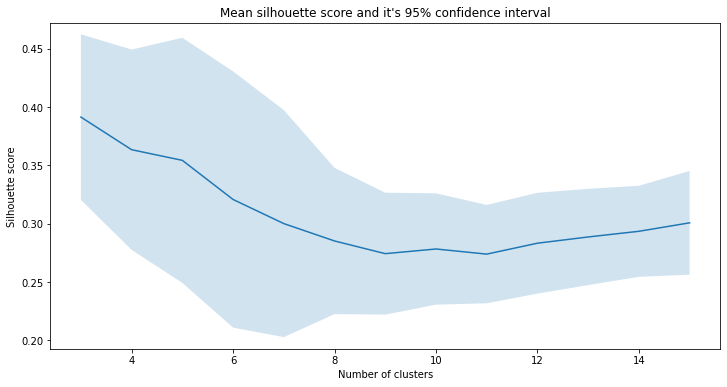

In [7]:
plt.figure(figsize=(12,6))
plt.plot(clstr_nums, scores)
plt.fill_between(clstr_nums, ci0, ci1, alpha=0.2)
plt.ylim(np.min(ci0)-0.01, np.max(ci1)+0.01)
plt.title("Mean silhouette score and it's 95% confidence interval")
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.savefig('../imgs/classical_clustering_sl_ti.png')
plt.show()
